In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
import numpy as np
from Utils.nmt_utils import load_dataset, preprocess_data, string_to_int
from keras.utils import to_categorical
from keras.utils import plot_model

2024-04-01 21:28:01.164175: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 21:28:01.164205: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 21:28:01.165063: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
m = 10_000
dataset, src_vocab, dest_vocab, inv_dest_vocab = load_dataset(m)

100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 35051.79it/s]


In [3]:
dataset[:10]

[('8 aug 1992', '1992-08-08'),
 ('21.07.70', '1970-07-21'),
 ('10/8/14', '2014-10-08'),
 ('saturday march 15 1986', '1986-03-15'),
 ('wednesday december 27 1989', '1989-12-27'),
 ('friday july 4 1980', '1980-07-04'),
 ('friday september 15 2000', '2000-09-15'),
 ('09 oct 1978', '1978-10-09'),
 ('28 sep 1976', '1976-09-28'),
 ('sunday june 27 1993', '1993-06-27')]

In [4]:
Tx = 30
Ty = 10
X, Y, Xoh, Yoh = preprocess_data(dataset, src_vocab, dest_vocab, Tx, Ty)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

X.shape: (10000, 30)
Y.shape: (10000, 10)
Xoh.shape: (10000, 30, 37)
Yoh.shape: (10000, 10, 11)


In [5]:
index = 0
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):", X[index])
print("Target after preprocessing (indices):", Y[index])
print()
print("Source after preprocessing (one-hot):", Xoh[index])
print("Target after preprocessing (one-hot):", Yoh[index])

Source date: 8 aug 1992
Target date: 1992-08-08

Source after preprocessing (indices): [11  0 13 31 19  0  4 12 12  5 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36]
Target after preprocessing (indices): [ 2 10 10  3  0  1  9  0  1  9]

Source after preprocessing (one-hot): [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Target after preprocessing (one-hot): [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


## Define the model

In [6]:
from keras.layers import RepeatVector, Dense, Activation, Concatenate, Dot, LSTM, Input, Bidirectional

In [7]:
def softmax(x, axis=1):
    """Softmax activation function.
    # Arguments
        x : Tensor.
        axis: Integer, axis along which the softmax normalization is applied.
    # Returns
        Tensor, output of softmax transformation.
    # Raises
        ValueError: In case `dim(x) == 1`.
    """
    ndim = keras.backend.ndim(x)
    if ndim == 2:
        return Activation('softmax')(x)
    elif ndim > 2:
        e = tf.exp(x - tf.reduce_max(x, axis=axis, keepdims=True))
        s = tf.reduce_sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D')

In [8]:
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation='tanh')
densor2 = Dense(1, activation='relu')
activator = Activation(softmax, name='attention_weights')
dotor = Dot(axes=1)

In [9]:
def one_step_attention(a, s_prev):
    """ 
    args:
        s_prev has the shape of (batches, n_s)
        a has the shape of (batches, Tx, n_a)

    returns:
        a model that takes (a, s_prev) and returns the context with the shape
    """
    # repeats s_prev to have the shape (batches, Tx, n_s)
    s_prev = repeator(s_prev)
    # concatenates s_prev to a to shape (batches, Tx, n_s + n_a)
    concat = concatenator([a, s_prev])
    # calculates "e" using a small fully-connected network to shape (batches, Tx, 10)
    e = densor1(concat)
    # calculates energies as the output of the small fully-connected network to shape (batches, Tx, 1)
    energies = densor2(e)
    # softmax is applied to each batch according to their sequence energies
    alphas = activator(energies)
    # Calculates alphas(batches, Tx, 1) @ a(batches, Tx, n_a) resulting in (batches, 1, n_a)
    context = dotor([alphas, a])
    return context

In [10]:
n_a = 32
n_s = 64

post_attention_LSTM = LSTM(units=n_s, return_state=True)
output_layer = Dense(units=len(dest_vocab), activation=softmax, name='output')

2024-04-01 21:28:05.294320: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


In [11]:
def get_uncompiled_model(Tx, Ty, n_a, n_s, src_vocab_size, dest_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_a -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    src_vocab_size -- size of the python dictionary "src_vocab"
    dest_vocab_size -- size of the python dictionary "dest_vocab"

    Returns:
    model -- Keras model instance
    """
    # Shape of X will be (None, Tx, vocab_size) since it is one_hot encoded
    X = Input(shape=(Tx, src_vocab_size))
    # Shape of s0 will be (None, n_s)
    s0 = Input(shape=(n_s, ), name='s0')
    # Shape of c0 will be (None, n_s)
    c0 = Input(shape=(n_s, ), name='c0')
    s = s0
    c = c0

    # outputs will be returned with the length of Ty
    outputs = []
    a = Bidirectional(LSTM(units=n_a, return_sequences=True))(X)

    for t in range(Ty):
        # Shape of context will be (batches, 1, n_a)
        context = one_step_attention(a, s0)
        s, _, c = post_attention_LSTM(context, initial_state=[s, c])
        out = output_layer(s)
        outputs.append(out)

    # every forward-prop generates Ty tokens all together then calculates loss for all 
    return keras.models.Model(inputs=[X, s0, c0], outputs=outputs)

In [12]:
model = get_uncompiled_model(Tx, Ty, n_a, n_s, len(src_vocab), len(dest_vocab))

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30, 37)]             0         []                            
                                                                                                  
 s0 (InputLayer)             [(None, 64)]                 0         []                            
                                                                                                  
 bidirectional (Bidirection  (None, 30, 64)               17920     ['input_1[0][0]']             
 al)                                                                                              
                                                                                                  
 repeat_vector (RepeatVecto  (None, 30, 64)               0         ['s0[0][0]',              

In [14]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
s0 = np.zeros((m, n_s), dtype='float32')
c0 = np.zeros((m, n_s), dtype='float32')
# Outputs should have Ty arrays with the shape of (batches, src_vocab_size)
outputs = list(Yoh.swapaxes(0,1))

In [16]:
history = model.fit([Xoh, s0, c0], outputs, epochs=60, batch_size=64)

Epoch 1/60
157/157 [==============================] - 19s 21ms/step - loss: 19.5903 - output_loss: 1.6852 - output_1_loss: 1.4739 - output_2_loss: 2.0931 - output_3_loss: 2.7662 - output_4_loss: 1.1669 - output_5_loss: 1.6680 - output_6_loss: 2.8498 - output_7_loss: 1.3183 - output_8_loss: 1.8827 - output_9_loss: 2.6864 - output_accuracy: 0.2450 - output_1_accuracy: 0.5088 - output_2_accuracy: 0.2302 - output_3_accuracy: 0.0750 - output_4_accuracy: 0.8686 - output_5_accuracy: 0.0589 - output_6_accuracy: 0.0044 - output_7_accuracy: 0.9305 - output_8_accuracy: 0.1511 - output_9_accuracy: 0.0760
Epoch 2/60
157/157 [==============================] - 3s 20ms/step - loss: 11.2013 - output_loss: 0.5329 - output_1_loss: 0.3301 - output_2_loss: 1.3797 - output_3_loss: 2.3823 - output_4_loss: 0.0973 - output_5_loss: 0.5918 - output_6_loss: 2.2635 - output_7_loss: 0.1416 - output_8_loss: 1.2273 - output_9_loss: 2.2548 - output_accuracy: 0.8679 - output_1_accuracy: 0.9407 - output_2_accuracy: 0.39

## Prediction

In [17]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
for example in EXAMPLES:
    
    source = string_to_int(example, Tx, src_vocab)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(src_vocab)), source)))
    source = source[None, ...]
    c0 = np.zeros((1, n_s))
    s0 = np.zeros((1, n_s))
    prediction = model.predict([source, s0, c0])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_dest_vocab[int(i)] for i in prediction]
    
    print("source:", example)
    print("output:", ''.join(output))

1/1 [==============================] - 4s 4s/step
source: 3 May 1979
output: 1979-05-03
1/1 [==============================] - 0s 18ms/step
source: 5 April 09
output: 2009-04-05
1/1 [==============================] - 0s 17ms/step
source: 21th of August 2016
output: 2016-08-22
1/1 [==============================] - 0s 16ms/step
source: Tue 10 Jul 2007
output: 2007-06-10


/tmp/ipykernel_10005/2173824436.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output = [inv_dest_vocab[int(i)] for i in prediction]


1/1 [==============================] - 0s 19ms/step
source: Saturday May 9 2018
output: 2018-05-09
1/1 [==============================] - 0s 17ms/step
source: March 3 2001
output: 2001-03-03
1/1 [==============================] - 0s 19ms/step
source: March 3rd 2001
output: 2001-03-03
1/1 [==============================] - 0s 20ms/step
source: 1 March 2001
output: 2001-03-01


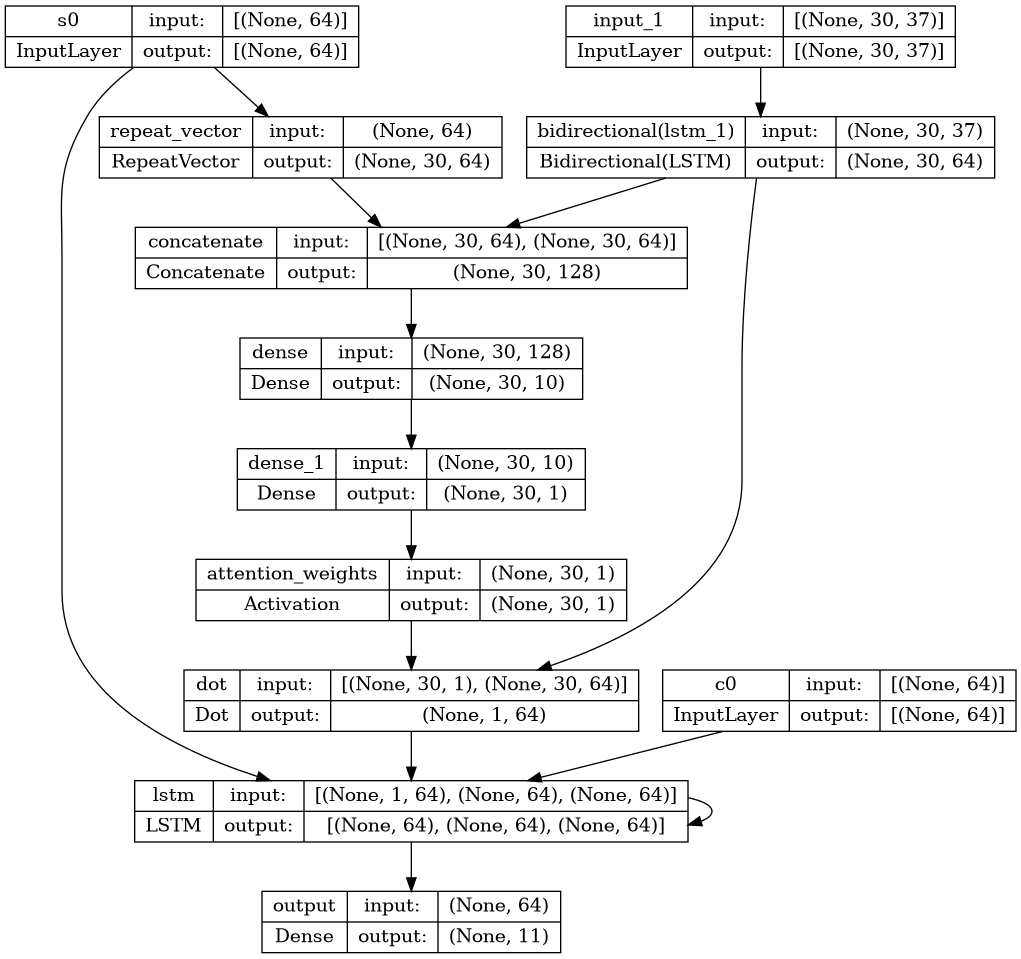

In [21]:
plot_model(model, show_shapes=True)